In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Constants
train_path = "/kaggle/input/guitar-chords-v3/Training"
test_path = "/kaggle/input/guitar-chords-v3/Test"
sr = 16000  
n_mfcc = 80  
N_CLASSES = 8  

def extract_mfcc(file_path, sr=sr, n_mfcc=n_mfcc):
    audio, _ = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

def load_data(data_path):
    X = []
    Y = []
    class_names = sorted(os.listdir(data_path))
    class_to_index = {cls_name: idx for idx, cls_name in enumerate(class_names)}
    
    print(f"Loading data from {data_path}")
    print(f"Found {len(class_names)} classes: {class_names}")
    
    for cls_name in class_names:
        cls_folder = os.path.join(data_path, cls_name)
        if not os.path.isdir(cls_folder):
            continue
        
        file_count = 0
        for file in os.listdir(cls_folder):
            file_path = os.path.join(cls_folder, file)
            try:
                features = extract_mfcc(file_path)
                X.append(features)
                Y.append(class_to_index[cls_name])
                file_count += 1
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        
        print(f"Loaded {file_count} files for class '{cls_name}'")
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y, class_names

print("Loading training data...")
X_train, Y_train, class_names_train = load_data(train_path)
print("\nLoading testing data...")
X_test, Y_test, class_names_test = load_data(test_path)

print("\nDataset Information:")
print(f"Training set: {X_train.shape[0]} samples, {n_mfcc} features")
print(f"Testing set: {X_test.shape[0]} samples, {n_mfcc} features")
print(f"Number of classes: {N_CLASSES}")

Y_train_categorical = to_categorical(Y_train, num_classes=N_CLASSES)
Y_test_categorical = to_categorical(Y_test, num_classes=N_CLASSES)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train_scaled, Y_train_categorical, test_size=0.2, random_state=42, stratify=Y_train
)

2025-04-18 09:51:40.102079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744969900.322453      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744969900.387272      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading training data...
Loading data from /kaggle/input/guitar-chords-v3/Training
Found 8 classes: ['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
Loaded 180 files for class 'Am'
Loaded 180 files for class 'Bb'
Loaded 180 files for class 'Bdim'
Loaded 180 files for class 'C'
Loaded 180 files for class 'Dm'
Loaded 180 files for class 'Em'
Loaded 180 files for class 'F'
Loaded 180 files for class 'G'

Loading testing data...
Loading data from /kaggle/input/guitar-chords-v3/Test
Found 8 classes: ['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
Loaded 40 files for class 'Am'
Loaded 40 files for class 'Bb'
Loaded 40 files for class 'Bdim'
Loaded 40 files for class 'C'
Loaded 40 files for class 'Dm'
Loaded 40 files for class 'Em'
Loaded 40 files for class 'F'
Loaded 40 files for class 'G'

Dataset Information:
Training set: 1440 samples, 80 features
Testing set: 320 samples, 80 features
Number of classes: 8


In [2]:
import tensorflow as tf
def build_advanced_model(input_dim, n_classes):
    inputs = Input(shape=(input_dim,))
    
    x1 = Dense(512, kernel_regularizer=l2(0.0001))(inputs)
    x1 = BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU(alpha=0.1)(x1)
    x1 = Dropout(0.4)(x1)
    
    x2 = Dense(256, kernel_regularizer=l2(0.0001))(x1)
    x2 = BatchNormalization()(x2)
    x2 = tf.keras.layers.LeakyReLU(alpha=0.1)(x2)
    x2 = Dropout(0.3)(x2)
    
    x3 = Dense(128, kernel_regularizer=l2(0.0001))(x2)
    x3 = BatchNormalization()(x3)
    x3 = tf.keras.layers.LeakyReLU(alpha=0.1)(x3)
    x3 = Dropout(0.3)(x3)
    
    fusion = Concatenate()([
        Dense(64)(x1),
        Dense(64)(x2),
        Dense(64)(x3)
    ])
    
    x = Dense(64)(fusion)
    x = BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

**main building function**

In [3]:
model = build_advanced_model(n_mfcc, N_CLASSES)
model.summary()


callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_guitar_chord_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

EPOCHS = 100
BATCH_SIZE = 32

history = model.fit(
    X_train_final, Y_train_final,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


test_loss, test_acc = model.evaluate(X_test_scaled, Y_test_categorical)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

I0000 00:00:1744969975.475123      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744969975.475867      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 80)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │         41,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 256)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │         32,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │         16,448 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ dense_4[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├──────────────────────

 Total params: 279,944 (1.07 MB)

 Trainable params: 278,024 (1.06 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/100


I0000 00:00:1744969982.105603      71 service.cc:148] XLA service 0x78cfe8002610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744969982.106394      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744969982.106415      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744969982.615039      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5416 - loss: 1.4274 

I0000 00:00:1744969986.126282      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.98611, saving model to best_guitar_chord_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6459 - loss: 1.1763 - val_accuracy: 0.9861 - val_loss: 0.1995 - learning_rate: 0.0010
Epoch 2/100
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9666 - loss: 0.2787 
Epoch 2: val_accuracy did not improve from 0.98611
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9691 - loss: 0.2672 - val_accuracy: 0.9861 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 3/100
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.1900 
Epoch 3: val_accuracy improved from 0.98611 to 0.99653, saving model to best_guitar_chord_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9880 - loss: 0.1913 - val_accuracy: 0.9965 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 4/100
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.1546 
Epoch 4: val_accuracy did not improve from 0.99653
36/36 ━━━━━━━━━━━━━

**visualizing the output curves**

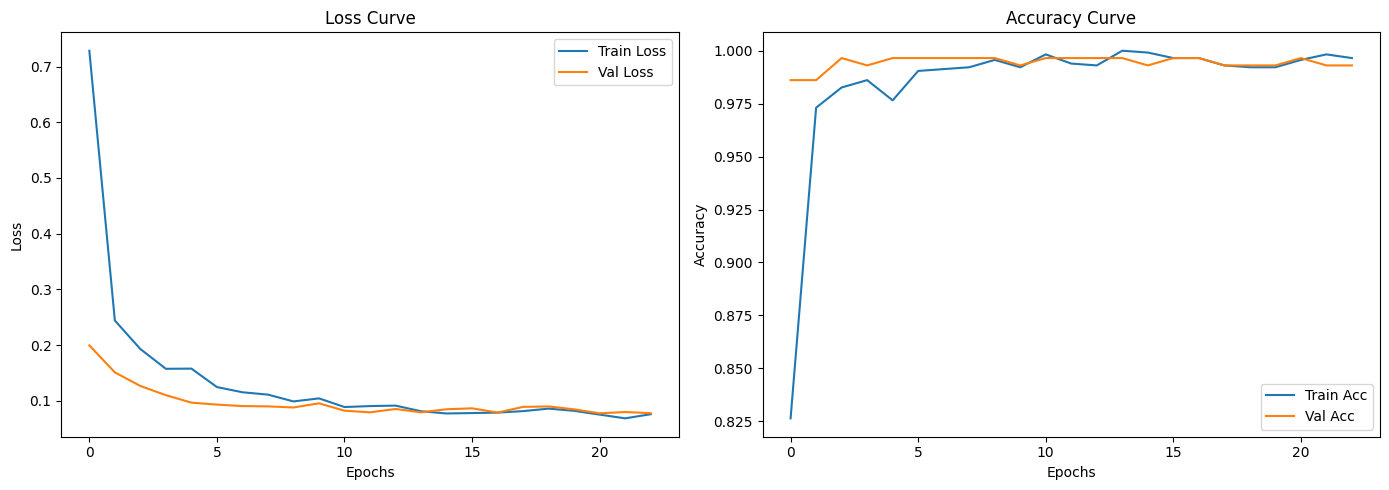


Final Training Accuracy: 99.65%
Final Validation Accuracy: 99.31%
Test Accuracy: 97.50%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


<Figure size 1000x800 with 0 Axes>

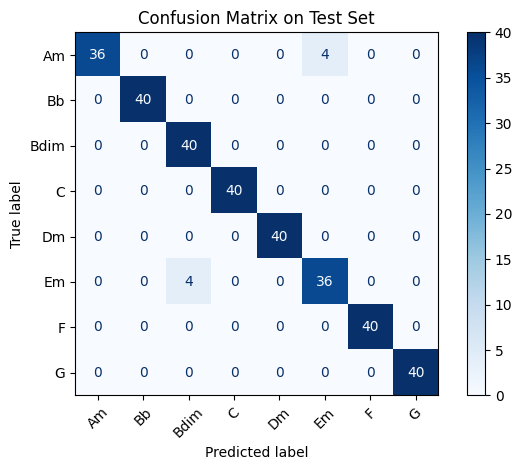

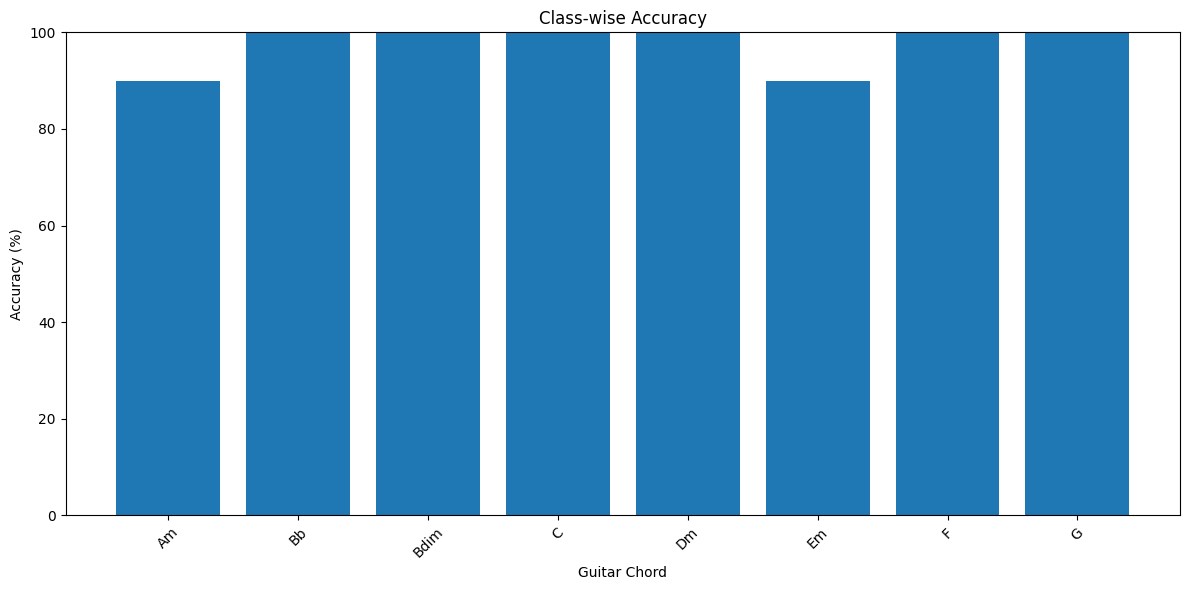

In [4]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("\nFinal Training Accuracy:", f"{final_train_acc*100:.2f}%")
print("Final Validation Accuracy:", f"{final_val_acc*100:.2f}%")
print("Test Accuracy:", f"{test_acc*100:.2f}%")

# Confusion matrix on test set
Y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
Y_true = Y_test

plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_test)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Class-wise accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.bar(class_names_test, class_accuracy * 100)
plt.title("Class-wise Accuracy")
plt.xlabel("Guitar Chord")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()